# Enhancing Post-Training Quantization with Z-Score Outlier Handling
[Run this tutorial in Google Colab](https://colab.research.google.com/github/sony/model_optimization/blob/main/tutorials/notebooks/mct_features_notebooks/pytorch/example_pytorch_activation_z_score_threshold.ipynb)

## Overview
This tutorial demonstrates the process used to find the activation z-score threshold, a step that MCT can use during post-training quantization.

In this example we will explore how setting different z scores effects threshold and accuracy. We will start by demonstrating how to apply the corresponding MCT configurations, then, we will feed a representative dataset through the model, plot the activation distribution of an activation layer with their respective MCT calculated z-score thresholds, and finally compare the quantized model accuracy of the examples of different z-score.

## Managing Outliers with Activation Z-Score Thresholding
During the quantization process, thresholds are used to map a distribution of 32-bit floating-point values to their quantized equivalents. Achieving this with minimal data loss while preserving the most representative range is crucial for maintaining the model’s final accuracy.

Some models can exhibit anomalous values when evaluated on a representative dataset. These outliers can negatively impact the range selection, leading to suboptimal quantization. To ensure a more reliable range mapping, it is beneficial to remove these values.

The **Model Compression Toolkit (MCT)** provides an option to filter out such outliers using **Z-score thresholding**, allowing users to exclude values based on their deviation from the standard distribution.

The Z-score of a value is calculated by subtracting the dataset’s mean from the value and then dividing by the standard deviation. This metric indicates how many standard deviations a particular value is away from the mean.



The threshold for outliers removal, $t$, is defined as a function of $Z_t$, the mean, $μ$, and the standard deviation, $σ$, of the activation values:

$$
t(Z_t) = μ + Z_t \cdot σ
$$


Where:

- $t(Z_t)$: The calculated threshold for outliers removal based on the Z-score threshold $Z_t$.
- $Z_t$: The chosen Z-score threshold. It indicates how many standard deviations an activation value must be from the mean to qualify for removal or special handling prior to quantization.
- $\mu = \frac{1}{n_s} \sum_{X \in F_l(D)} X$: The mean of activations
- $\sigma = \sqrt{\frac{1}{n_s} \sum_{X \in F_l(D)} (X - \mu)^2}$: The standard deviation of activations in $F_l(D)$.
    where:
    - $F_l(D)$: Represents the distribution of activation values.
    - $X$: An individual activation within the distribution.


This equation for $t(Z_t)$ enables the identification of activation values that deviate significantly from the mean, helping to remove outliers before the main quantization step. This process results in a more reliable range for mapping floating-point values to quantized representations, ultimately improving quantization accuracy.
## Setup
Install the relevant packages:

In [1]:
!pip install -q torch==2.5 torchvision

In [2]:
import importlib
if not importlib.util.find_spec('model_compression_toolkit'):
    !pip install model_compression_toolkit

In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision.datasets import ImageNet

Load a pre-trained MobileNetV2 model from torchvision, in 32-bits floating-point precision format.

In [4]:
weights = MobileNet_V2_Weights.IMAGENET1K_V2

float_model = mobilenet_v2(weights=weights)

## Dataset preparation
### Download the ImageNet validation set
Download the ImageNet dataset with only the validation split.

⚠️**Note:** For demonstration purposes we use the validation set for the model quantization routines. Usually, a subset of the training dataset is used, but loading it is a heavy procedure that is unnecessary for the sake of this demonstration.

This step may take several minutes...

In [5]:
import os
 
if not os.path.isdir('imagenet'):
    !mkdir imagenet
    !wget -P imagenet https://image-net.org/data/ILSVRC/2012/ILSVRC2012_devkit_t12.tar.gz
    !wget -P imagenet https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar

Extract ImageNet validation dataset using torchvision "datasets" module.

In [6]:
dataset = ImageNet(root='./imagenet', split='val', transform=weights.transforms())

## Representative Dataset
For quantization with MCT, we need to define a representative dataset required by the PTQ algorithm. This dataset is a generator that returns a list of images:

In [7]:
batch_size = 8
n_iter = 10

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

def representative_dataset_gen():
    dataloader_iter = iter(dataloader)
    for _ in range(n_iter):
        yield [next(dataloader_iter)[0]]

## Target Platform Capabilities
MCT optimizes the model for dedicated hardware. This is done using TPC (for more details, please visit our [documentation](https://sony.github.io/model_optimization/api/api_docs/modules/target_platform.html)). Here, we use the default Torch TPC:

In [8]:
import model_compression_toolkit as mct

# Get a TargetPlatformCapabilities object that models the hardware platform for the quantized model inference. Here, for example, we use the default platform that is attached to a Pytorch layers representation.
target_platform_cap = mct.get_target_platform_capabilities('pytorch', 'default')

## Post-Training Quantization using MCT
This step we quantize the model with a few Z-score thresholds.
The quantization parameters are predefined, and we use the default values except for the quantization method. Feel free to modify the code below to experiment with other Z-scores values.

In [9]:
# List of error methods to iterate over
q_configs_dict = {}

# Z-score values to iterate over
z_score_values = [3,5,9]

# Iterate and build the QuantizationConfig objects
for z_score in z_score_values:
    q_config = mct.core.QuantizationConfig(
        z_threshold=z_score,
    )
    q_configs_dict[z_score] = q_config

Now we will run post-training quantization for each configuration:

In [10]:
quantized_models_dict = {}

for z_score, q_config in q_configs_dict.items():
    # Create a CoreConfig object with the current quantization configuration
    ptq_config = mct.core.CoreConfig(quantization_config=q_config)

    # Perform MCT post-training quantization
    quantized_model, quantization_info = mct.ptq.pytorch_post_training_quantization(
        in_module=float_model,
        representative_data_gen=representative_dataset_gen,
        core_config=ptq_config,
        target_platform_capabilities=target_platform_cap
    )

    # Update the dictionary to include the quantized model
    quantized_models_dict[z_score] = {
        "quantization_config": q_config,
        "quantized_model": quantized_model,
        "quantization_info": quantization_info
    }


Statistics Collection: 10it [00:10,  1.08s/it]
Calculating quantization parameters: 100%|██████████| 102/102 [00:17<00:00,  5.79it/s]
Statistics Collection: 10it [00:11,  1.15s/it]
Calculating quantization parameters: 100%|██████████| 102/102 [00:17<00:00,  5.84it/s]
Statistics Collection: 10it [00:13,  1.32s/it]
Calculating quantization parameters: 100%|██████████| 102/102 [00:17<00:00,  5.91it/s]


### Z-Score Threshold and Distribution Visualization
To aid in understanding, we will plot the activation distribution of an activation layer in MobileNetV2. This distribution will be generated by inferring a representative dataset through the model.

To visualize the activations, the model must be rebuilt up to and including the selected layer. Once the activations are extracted, we can calculate their Z-score threshold values manually using the equation provided in the introduction.

Before plotting the distribution, we need to list the layer names. With PyTorch, this can be done easily using the following code. We determined the index of the layer of interest through a series of checks, which are detailed in the appendix section.

In [11]:
# Print layer name
layer_name = 'features.6.conv.2'
layer = dict(float_model.named_modules())[layer_name]

# Add hook
def get_layer_output(model, layer_name):
    outputs = {}

    def hook(module, input, output):
        outputs[layer_name] = output

    # Add hook
    layer = dict(model.named_modules())[layer_name]
    layer.register_forward_hook(hook)

    return outputs

output_dict_relu = get_layer_output(float_model, layer_name)

Infer the representative dataset using these models and store the outputs for further analysis.

In [12]:
from tqdm import tqdm
import numpy as np

activation_batches_relu = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    float_model = float_model.to(device)
    for index, data in enumerate(tqdm(representative_dataset_gen())):
        images = data[0]
        images = images.to(device)

        float_model(images)

        activations_relu = output_dict_relu[layer_name]
        activation_batches_relu.append(activations_relu.to('cpu').detach().numpy().copy())
        
    all_activations_relu = np.concatenate(activation_batches_relu, axis=0).flatten()

10it [00:00, 11.70it/s]


We can compute the Z-score for a layer using the formulas provided in the introduction.

In [13]:
z_thresholds_relu = {}

# Calculate the mean and standard deviation of the activation data
mean = np.mean(all_activations_relu)
std_dev = np.std(all_activations_relu)

# Calculate and store the threshold for each Z-score
for zscore in z_score_values:
    z_threshold = zscore * std_dev + mean
    z_thresholds_relu[f'z-score {zscore}'] = z_threshold

### Distribution Plots
In this section, we visualize the activation distribution from the constructed model along with the corresponding Z-score thresholds.
From this list, we randomly select layers and evaluate their corresponding thresholds.

In [14]:
mse_error_thresholds = {
    z_score: data["quantized_model"].features_6_conv_0_2_activation_holder_quantizer.activation_holder_quantizer.threshold_np
    for z_score, data in quantized_models_dict.items()
}
print(mse_error_thresholds)

{3: 4.0, 5: 8.0, 9: 8.0}


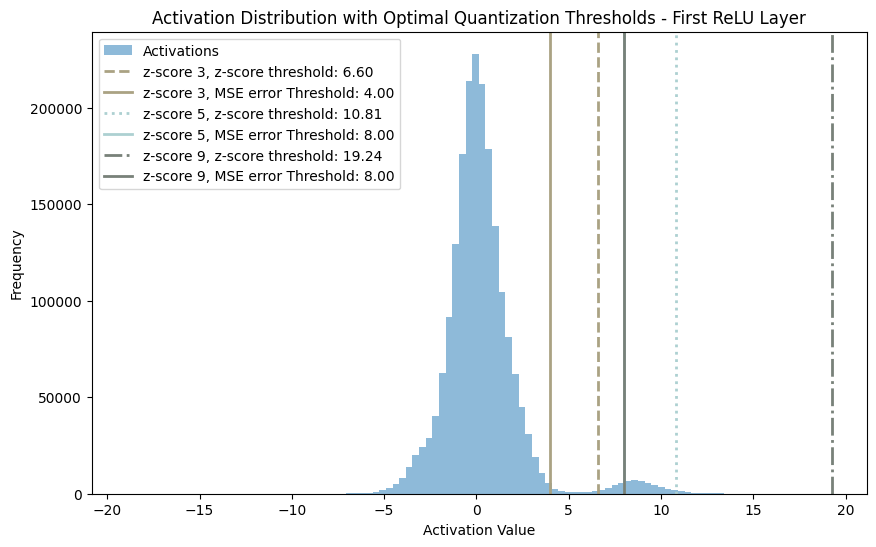

In [15]:
import matplotlib.pyplot as plt
import numpy as np

ls_table = ['--', ':', '-.', '--', ':']

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(all_activations_relu, bins=100, alpha=0.5, label='Activations')
for index, (z_score, threshold) in enumerate(z_thresholds_relu.items()):
    random_color=np.random.rand(3,)
    plt.axvline(threshold, linestyle=ls_table[index], linewidth=2, color=random_color, label=f'{z_score}, z-score threshold: {threshold:.2f}')
    z_score_1 = int(z_score.split(' ')[1])  # Splits the string and converts the second element to an integer
    error_value = mse_error_thresholds[z_score_1]  # Now using the correct integer key to access the value
    plt.axvline(error_value, linestyle='-', linewidth=2, color=random_color, label=f'{z_score}, MSE error Threshold: {error_value:.2f}')

plt.title('Activation Distribution with Optimal Quantization Thresholds - First ReLU Layer')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The impact of the Z-score on the error threshold is clearly visible here. A lower Z-score, such as 3, decreases the error threshold for the given layer.

## Model Evaluation
Finally, we can demonstrate how varying Z-score thresholds affect the model's accuracy.
In order to evaluate our models, we first need to load the validation dataset.

In [16]:
val_dataset = ImageNet(root='./imagenet', split='val', transform=weights.transforms())
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [17]:
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn

def evaluate(model, test_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    
    return test_loss, accuracy 

_, float_accuracy = evaluate(float_model, val_loader)
print(f"Float model's Top 1 accuracy on the Imagenet validation set: {(float_accuracy * 100.0):.2f}%")

100%|██████████| 391/391 [06:57<00:00,  1.07s/it]

Float model's Top 1 accuracy on the Imagenet validation set: 70.99%


In [18]:
#prepare quantised models and evaluate
evaluation_results = {}

for error_method, data in quantized_models_dict.items():
    quantized_model = data["quantized_model"]

    results = evaluate(quantized_model, val_loader)

    evaluation_results[error_method] = results

    # Print the results
    print(f"Results for {error_method}: Loss = {results[0]}, Accuracy = {results[1]}")


100%|██████████| 391/391 [05:57<00:00,  1.09it/s]


Results for 3: Loss = 5.197937669677734, Accuracy = 0.27044


100%|██████████| 391/391 [03:56<00:00,  1.65it/s]


Results for 5: Loss = 3.4991744610595705, Accuracy = 0.49772


100%|██████████| 391/391 [05:56<00:00,  1.10it/s]

Results for 9: Loss = 1.8203825662231445, Accuracy = 0.71846


We observe only minor improvements when adjusting the Z-score threshold. This pattern is common for most simple models. However, our testing shows that transformer models tend to benefit more from outlier removal. It is advisable to experiment with these parameters if the quantized accuracy is noticeably lower than the float model’s accuracy.

## Conclusion
In this tutorial, we demonstrated the use of Z-score thresholding as a critical step in the quantization process. This technique helps refine activation ranges by removing outliers, ultimately leading to improved quantized model accuracy. You can use the provided code as a starting point to experiment with selecting optimal Z-score thresholds for your own models.

Our testing indicates that the optimal Z-score threshold typically falls between 8 and 12. Setting the threshold above 12 tends to show negligible improvement, while values below 8 may distort the distribution. However, finding the right threshold will require experimentation based on the specific characteristics of your model and use case.

By applying Z-score thresholding thoughtfully, you can mitigate quantization errors and ensure that the quantized model's performance remains as close as possible to that of the original floating-point version.

## Appendix
Below are selected code samples used to identify the most suitable layers for plotting thresholds and distributions.

**Listing Layers Affected by Z-Score Adjustments**
The following code snippet provides a list of layers that are impacted by Z-score thresholding, helping to determine which layers to focus on when visualizing distributions:

In [19]:
# Initialize a dictionary to hold threshold values for comparison
thresholds_by_index = {}

# Try to access each layer for each quantized model and collect threshold values
for z_score, data in quantized_models_dict.items():
    quantized_model = data["quantized_model"]
    module_list =[module for module in quantized_model.modules()]
    for layer_index in range(1, len(module_list)):
        try:
            # Attempt to access the threshold value for this layer
            threshold = module_list[layer_index].activation_holder_quantizer.threshold_np
            # Store the threshold value for comparison
            if layer_index not in thresholds_by_index:
                thresholds_by_index[layer_index] = set()
            thresholds_by_index[layer_index].add(threshold)
        except Exception as e:
            pass

# Find indices where threshold values are not consistent
inconsistent_indices = [index for index, thresholds in thresholds_by_index.items() if len(thresholds) > 1]

print("Inconsistent indices:", inconsistent_indices)


Inconsistent indices: [13, 24, 35, 36, 47, 55, 58, 63, 67, 70, 75, 82, 86, 90, 93, 94, 98, 102, 105, 106, 110, 114, 117, 118, 122, 133, 137, 140, 141, 145, 149, 152, 153, 157, 164, 168, 172, 175, 180, 184, 187, 188, 192, 199, 203, 204, 208]



[!Under modification] Next, we want to verify which layers correspond to the indices based on the layer names in the original float model. For example, index 1 has no matching layer, as it represents a quantized version of the previous layer. However, checking index 51 reveals that it aligns with the layer named `conv_dw_8_relu`, which we can use to plot the distribution.

In [20]:
print('#####[!Under modification]#####')

import torch.nn as nn

target_z_score = 9

def get_leaf_layer_info(module, parent_name=''):
    leaf_layer_info = []
    
    # Iterate through all child modules with their names
    for name, child in module.named_children():
        # Construct the full name of the child layer
        full_name = f"{parent_name}.{name}" if parent_name else name
        
        # Recurse into the child module
        leaf_layer_info.extend(get_leaf_layer_info(child, full_name))
    
    # If it has no children, it's a leaf layer; add its name and type
    if not isinstance(module, nn.Sequential) and not isinstance(module, nn.ModuleList) and not list(module.children()):
        leaf_layer_info.append((parent_name, type(module).__name__))

    return leaf_layer_info

quantized_model = quantized_models_dict[target_z_score]["quantized_model"]

leaf_f_layer_info = get_leaf_layer_info(float_model)
leaf_f_layer_info = [(n.replace('.', '_'), l) for n, l in leaf_f_layer_info]
leaf_q_layer_info = get_leaf_layer_info(quantized_model)

for index, (name, layer) in enumerate(leaf_f_layer_info):
    search_string = str(name).replace('.', '_')
    #print("name", name)
    # Check if the target_z_score is in the quantized_models_dict
    if target_z_score in quantized_models_dict:
        #data = quantized_models_dict[target_z_score]
        # Iterate over each layer of the target quantized model
        for quantized_index, (quantized_name, quantized_layer) in enumerate(leaf_q_layer_info):
            found = search_string in str(quantized_name)
            # If found, print details including the indices of the matching layers
            if found:
                print(f"Float Model Layer Index {index} & Quantized Model Layer Index {quantized_index}: Found match in layer name  {search_string}, {quantized_name}")
    else:
        print(f"Z-Score {target_z_score} not found in quantized_models_dict.")


#####[!Under modification]#####
Float Model Layer Index 0 & Quantized Model Layer Index 2: Found match in layer name  features_0_0, features_0_0_bn.layer
Float Model Layer Index 2 & Quantized Model Layer Index 3: Found match in layer name  features_0_2, features_0_2
Float Model Layer Index 2 & Quantized Model Layer Index 4: Found match in layer name  features_0_2, features_0_2_activation_holder_quantizer
Float Model Layer Index 3 & Quantized Model Layer Index 5: Found match in layer name  features_1_conv_0_0, features_1_conv_0_0_bn.layer
Float Model Layer Index 5 & Quantized Model Layer Index 6: Found match in layer name  features_1_conv_0_2, features_1_conv_0_2
Float Model Layer Index 5 & Quantized Model Layer Index 7: Found match in layer name  features_1_conv_0_2, features_1_conv_0_2_activation_holder_quantizer
Float Model Layer Index 6 & Quantized Model Layer Index 8: Found match in layer name  features_1_conv_1, features_1_conv_1_bn.layer
Float Model Layer Index 6 & Quantized Mode



Copyright 2025 Sony Semiconductor Israel, Inc. All rights reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
